<a href="https://colab.research.google.com/github/udaykarthik4245/idp/blob/main/densenet%2Cmobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DENSENET

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
280/280 [==============================] - 52s 123ms/step - loss: 0.8352 - accuracy: 0.7978
Epoch 2/10
280/280 [==============================] - 37s 131ms/step - loss: 0.1709 - accuracy: 0.9500
Epoch 3/10
280/280 [==============================] - 34s 122ms/step - loss: 0.1099 - accuracy: 0.9710
Epoch 4/10
280/280 [==============================] - 34s 123ms/step - loss: 0.1413 - accuracy: 0.9634
Epoch 5/10
280/280 [==============================] - 34s 122ms/step - loss: 0.0618 - accuracy: 0.9821
Epoch 6/10
280/280 [==============================] - 36s 129ms/step - loss: 0.0533 - accuracy: 0.9848
Epoch 7/10
280/280 [==============================] - 35s 125ms/step - loss: 0.0809 - accuracy: 0.9754
Epoch 8/10
280/280 [==============================] - 37s 134ms/step - loss: 0.0774 - accuracy: 0.9759
Epoch 9/10
280/280 [==============================] - 35s 123ms/step - loss: 0.0882 - accuracy: 0.9754
Epoch 10

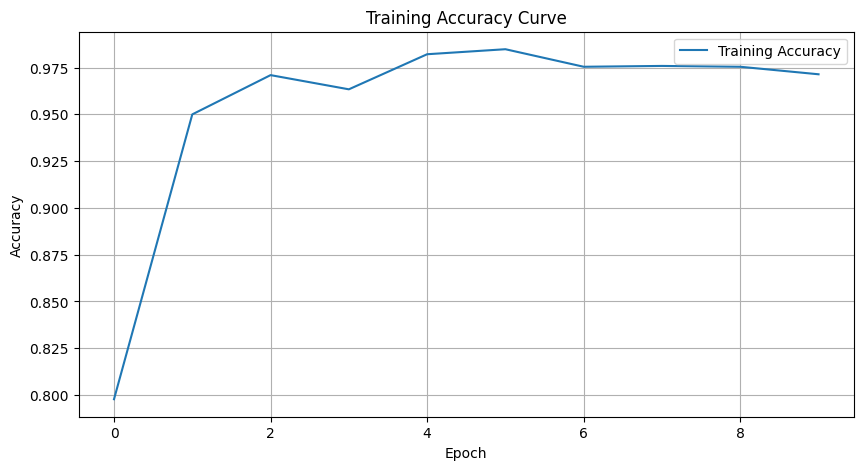

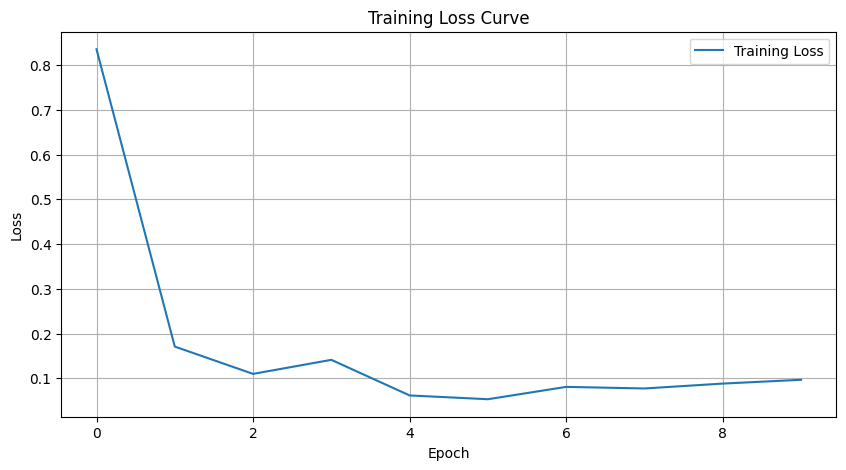

Test accuracy: 0.9857
18/18 [==============================] - 4s 93ms/step


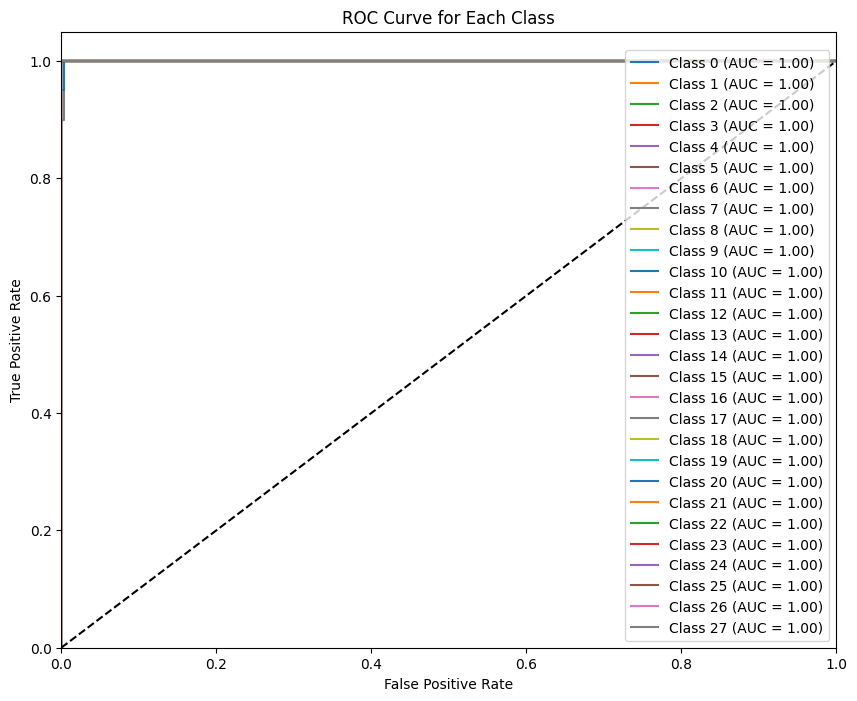

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      0.95      0.97        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00      0.80      0.89        20
          17       0.83    

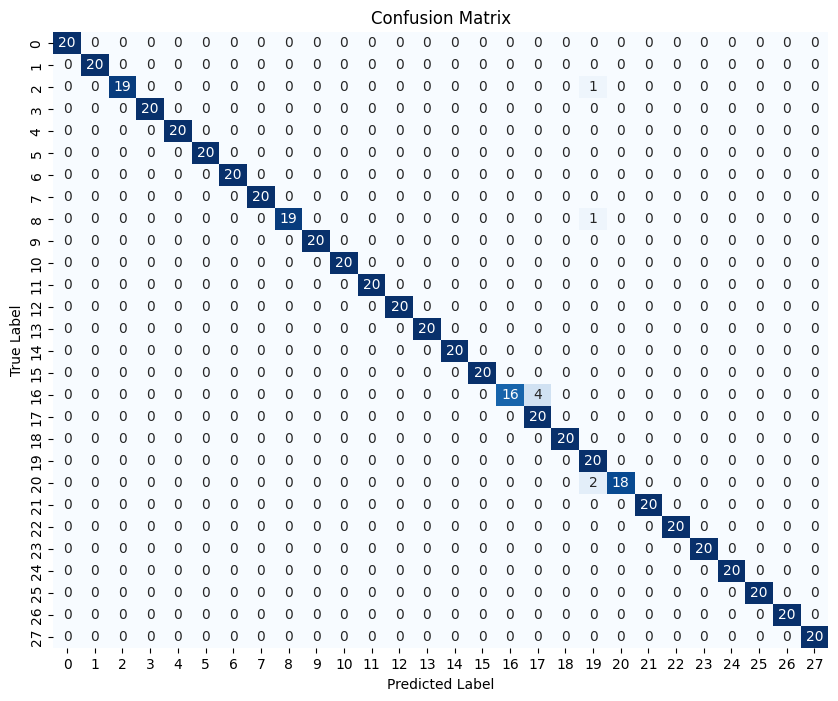

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

IMAGE_SIZE = (224, 224)
NUM_CLASSES = 28
NUM_EPOCHS = 10
BATCH_SIZE = 8

# Define path to train folder
train_data_dir = '/content/drive/MyDrive/resize dataset/training'

def load_images_from_folder(folder):
    images = []
    labels = []
    for class_label, class_name in enumerate(sorted(os.listdir(folder))):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img = load_img(os.path.join(class_folder, filename), target_size=IMAGE_SIZE)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_label)
    return np.array(images), np.array(labels)

# Load and preprocess data
x_train, y_train = load_images_from_folder(train_data_dir)
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train, NUM_CLASSES)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use DenseNet121 as the backbone and fine-tune it
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Freeze the weights of the pre-trained layers
base_model.trainable = False

opt = Adam(learning_rate=0.0001)  # Adjust learning rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(x_train) / BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1)

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test dataset
test_data_dir = '/content/drive/MyDrive/resize dataset/testing'
x_test, y_test = load_images_from_folder(test_data_dir)
x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test, NUM_CLASSES)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = model.predict(x_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
print(classification_report(y_true_labels, y_pred_labels))

# Generate confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


MOBILE NET

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

IMAGE_SIZE = (224, 224)
NUM_CLASSES = 28
NUM_EPOCHS = 10
BATCH_SIZE = 8

# Define path to train folder
train_data_dir = '/content/drive/MyDrive/resize dataset/training'

def load_images_from_folder(folder):
    images = []
    labels = []
    for class_label, class_name in enumerate(sorted(os.listdir(folder))):
        class_folder = os.path.join(folder, class_name)
        for filename in os.listdir(class_folder):
            img = load_img(os.path.join(class_folder, filename), target_size=IMAGE_SIZE)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_label)
    return np.array(images), np.array(labels)

# Load and preprocess data
x_train, y_train = load_images_from_folder(train_data_dir)
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train, NUM_CLASSES)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use MobileNetV2 as the backbone and fine-tune it
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Freeze the weights of the pre-trained layers
base_model.trainable = False

opt = Adam(learning_rate=0.0001)  # Adjust learning rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
          steps_per_epoch=len(x_train) / BATCH_SIZE, epochs=NUM_EPOCHS)

# Evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f'Overall training accuracy: {train_acc:.4f}')


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
280/280 [==============================] - 37s 119ms/step - loss: 0.8324 - accuracy: 0.8241
Epoch 2/10
280/280 [==============================] - 31s 111ms/step - loss: 0.1800 - accuracy: 0.9522
Epoch 3/10
280/280 [==============================] - 33s 117ms/step - loss: 0.2014 - accuracy: 0.9545
Epoch 4/10
280/280 [==============================] - 32s 116ms/step - loss: 0.2095 - accuracy: 0.9585
Epoch 5/10
280/280 [==============================] - 32s 114ms/step - loss: 0.1378 - accuracy: 0.9670
Epoch 6/10
280/280 [==============================] - 31s 111ms/step - loss: 0.0679 - accuracy: 0.9830
Epoch 7/10
280/280 [==============================] - 31s 111ms/step - loss: 0.0757 - accuracy: 0.9786
Epoch 8/10
280/280 [==============================] - 32s 114ms/step - loss: 0.0825 - accuracy: 0.9826
Epoch 9/10
280/280 [==============================] - 34s 123ms/step - loss: 0.0905 - accuracy: 0.9839
Epoch 10/1

In [5]:
# Define path to test folder
test_data_dir = '/content/drive/MyDrive/resize dataset/testing'

# Load test data
x_test, y_test = load_images_from_folder(test_data_dir)
x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
# Generate predictions
y_pred = model.predict(x_test)

Test accuracy: 0.9929
18/18 [==============================] - 2s 40ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      0.80      0.89        20
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        20
          17       1.00    

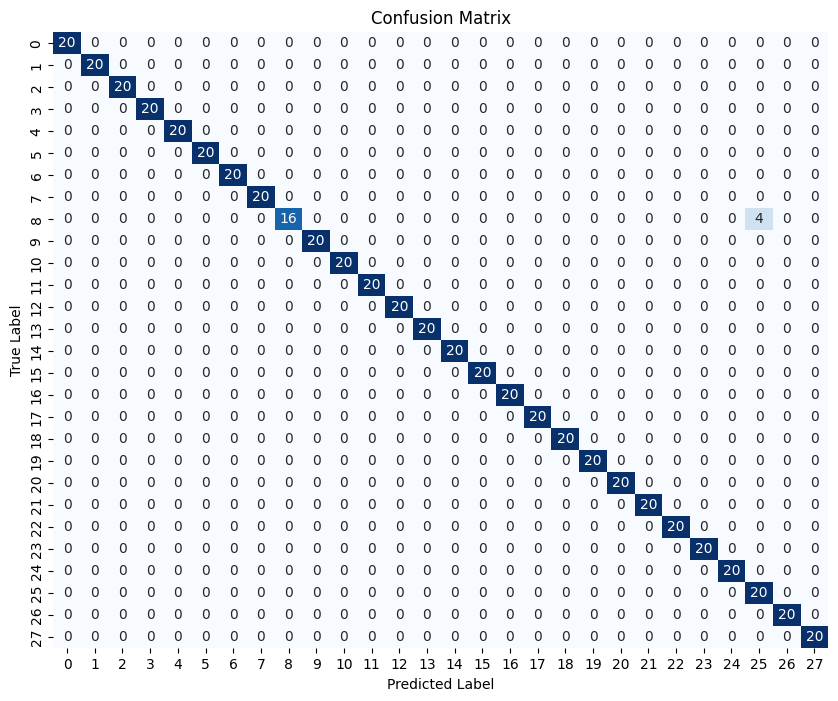

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_labels, y_pred_labels))

# Print confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
print(conf_mat)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
